In [1]:
!pip install mpld3
import mpld3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Just for some data
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import plotnine
from plotnine import *
from plotnine import ggplot, geom_boxplot, aes, theme, element_text, element_blank, scale_y_log10, labs, element_rect, guides, scale_color_manual
from plotnine.themes import theme_minimal
from plotnine.geoms import geom_hline, geom_jitter
from plotnine.scales import scale_fill_brewer
from plotnine import facet_wrap
from mizani.breaks import date_breaks
import plotly.express as px # used for interactive visualizations
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.offline import init_notebook_mode, iplot # plot plotly graphs in line in a notebook
import pycountry
import calendar

import warnings        
warnings.filterwarnings("ignore") # ignores warnings

### **`About Dataset` : This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.**
### **`source` : http://archive.ics.uci.edu/dataset/352/online+retail**
### **`Cleaned data source` : https://www.kaggle.com/datasets/atanaskanev/online-retail-business-cleaned-dataset**


### **Description of all columns**

![Description of data](description.png)

In [2]:
data = pd.read_csv('online_retail_cleaned.csv')

In [3]:
print(f"Shape of DataFrame : {data.shape}")
print(f"Columns : {data.columns}")

Shape of DataFrame : (537966, 9)
Columns : Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'ItemTotal'],
      dtype='object')


In [4]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [5]:
data.head(10)
data[0:10].to_html("table_head.html", escape=False)

In [6]:
print(f"Different countries where customers resides : {len(set(data['Country']))}")

Different countries where customers resides : 38


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537966 entries, 0 to 537965
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    537966 non-null  object        
 1   StockCode    537966 non-null  object        
 2   Description  537966 non-null  object        
 3   Quantity     537966 non-null  int64         
 4   InvoiceDate  537966 non-null  datetime64[ns]
 5   UnitPrice    537966 non-null  float64       
 6   CustomerID   405542 non-null  float64       
 7   Country      537966 non-null  object        
 8   ItemTotal    537966 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 36.9+ MB


In [8]:
# Checking for Nan Data
data.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132424
Country             0
ItemTotal           0
dtype: int64

In [9]:
Countries_where_customers_resides = set(data['Country'])

### **We'll start with visualizing the sales covering different countries**
- As plotnine has no library to plot pie chart so we'll use plotly for this

In [10]:
# calculate total sales by country
country_sales = pd.DataFrame(data.groupby("Country") \
["ItemTotal"].sum()).reset_index().rename({"ItemTotal":"TotalSales"},axis=1)

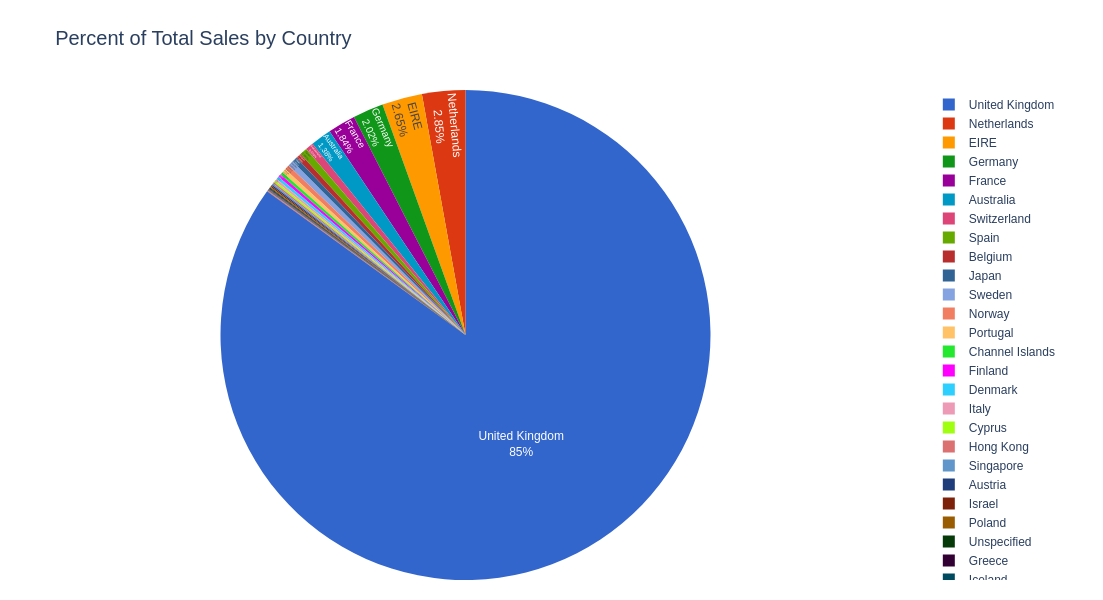

In [11]:
fig = px.pie(country_sales,
             values="TotalSales",
             names="Country",
             title="Percent of Total Sales by Country",
             color_discrete_sequence=px.colors.qualitative.G10
            )

fig.update_traces(
                  textposition="inside",
                  textinfo="percent+label"
                 )
fig.update_layout(
                  margin=dict(l=20, r=70, b=20, t=90, pad=0),
                  titlefont=dict(size=20),
                  width=800,  
                  height=600  
                 )

# Save the animation as an HTML file
plot(fig, filename='Percent of Total Sales by Country.html', auto_open=False)

iplot(fig)

### *We can see barplot using plotnine*
- We will plot this chart without the UK sales since it would skew the scale due to its predominant share of sales.

In [12]:
# also drop "Unspecified" and "European Community" since they cannot be mapped
country_sales = country_sales[country_sales["Country"] \
.isin(["Unspecified", "European Community","United Kingdom"]) == False]

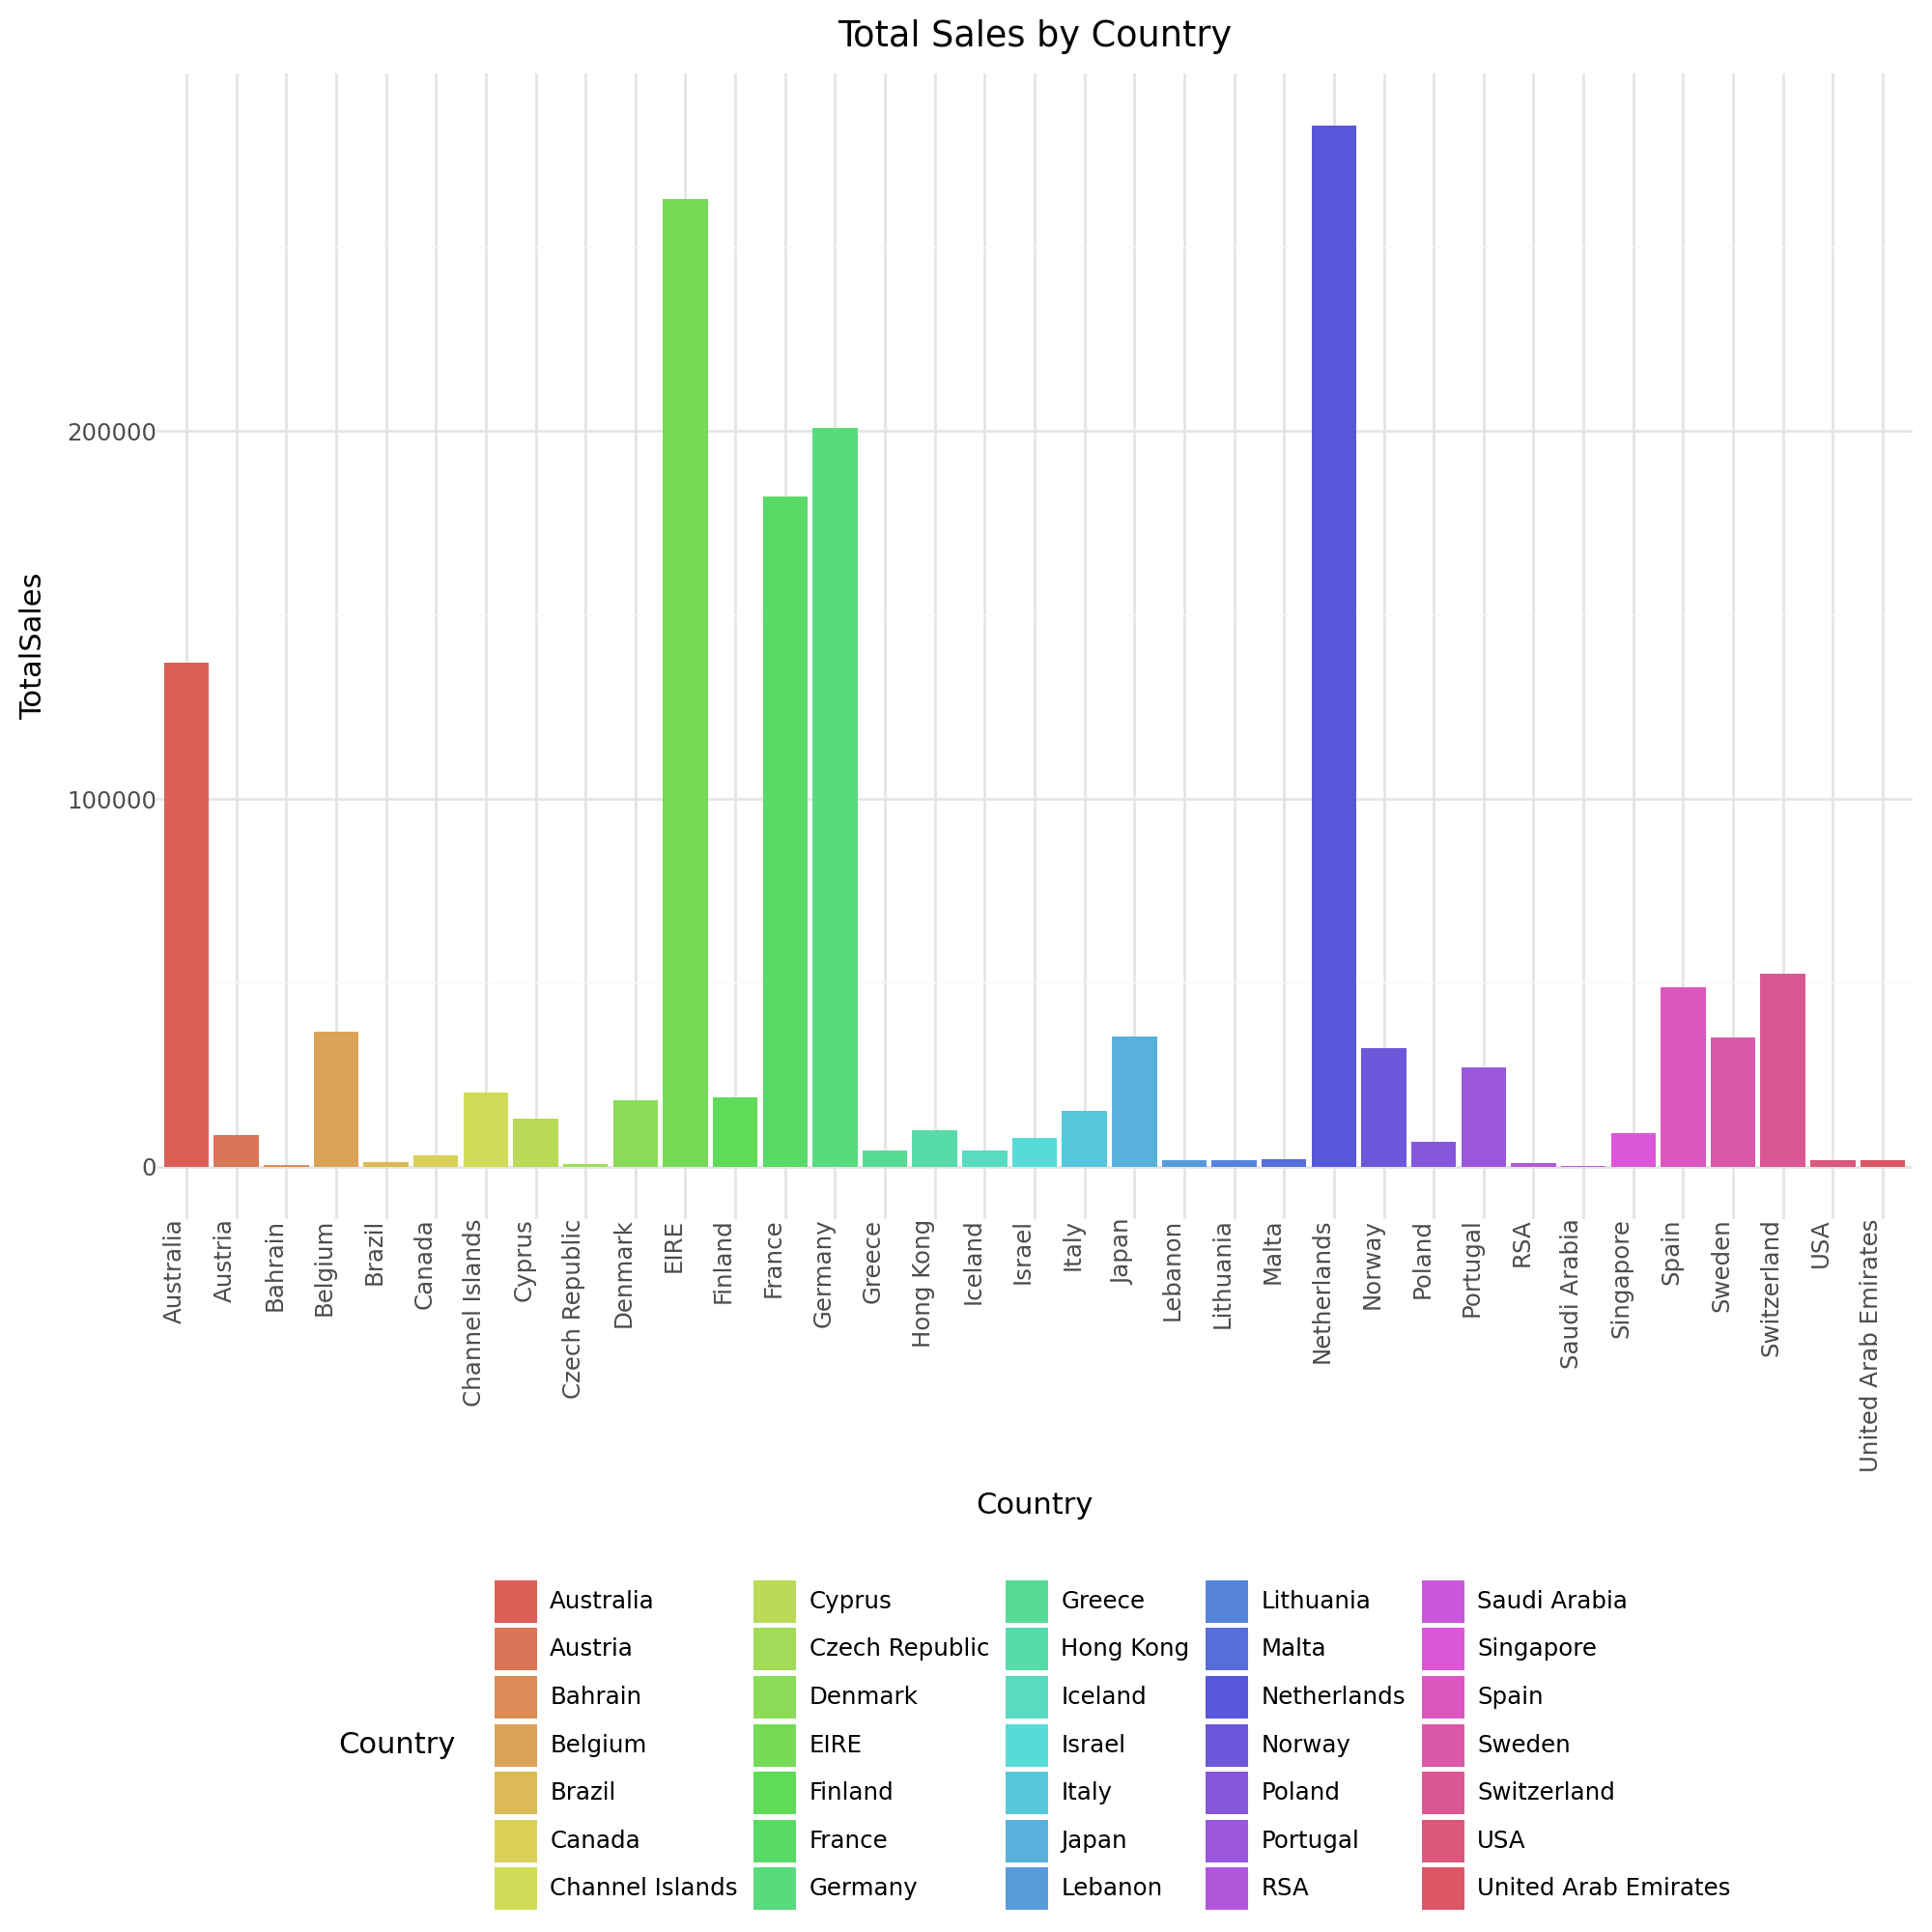

In [13]:
# Create bar plot using Plotnine
bar_plot = (
    ggplot(country_sales, aes(x='Country', y='TotalSales', fill='Country')) +
    geom_bar(stat='identity') +
    labs(title="Total Sales by Country") +
    theme_minimal() +
    theme(axis_text_x=element_text(angle=90, hjust=1),
          legend_position='bottom',
          figure_size=(10, 10)) 
)

bar_plot.save("bar_plot.jpg")

bar_plot.show()

### *Let's visualize other countries' share of total sales by plotting the sales figure on a map. We will plot this map without the UK sales since it would skew the scale due to its predominant share of sales.*

In [14]:
# rename countries into names which are recognised by plotly
country_sales["Country"] = \
country_sales["Country"].replace({"EIRE": "Ireland",
                                  "Channel Islands": "United Kingdom",
                                  "RSA": "South Africa"})

### *We'll use plotly to show interactive plot of sales of different countries**

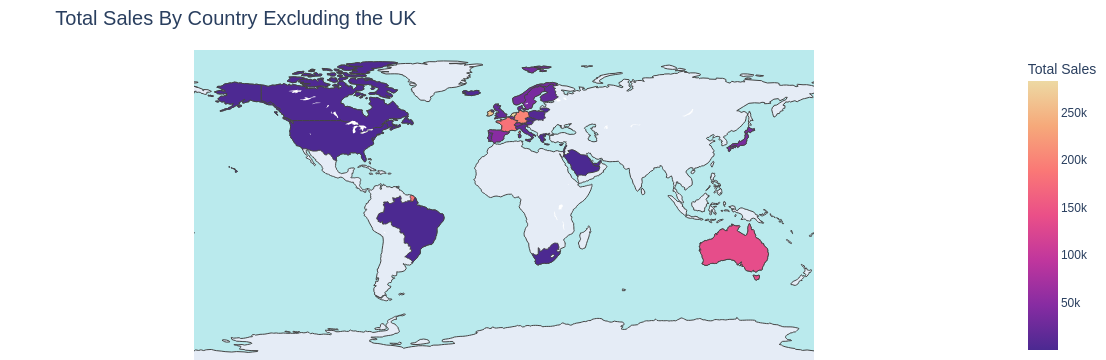

In [15]:
# https://stackoverflow.com/questions/59812824/plotly-express-plot-not-shown-in-jupyter-notebook
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = country_sales["Country"],
                  locationmode = "country names",
                  z = country_sales["TotalSales"].astype(float).round(0).tolist(),
                  hovertext = country_sales["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  # https://stackoverflow.com/questions/59057881/python-plotly-how-to-customize-hover-template-on-with-what-information-to-show
                  colorbar = {"title" : "Total Sales", },
                ) 

layout = dict(
              title = "Total Sales By Country Excluding the UK",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)

# Save the animation as an HTML file
plot(fig, filename='total_sales_map.html', auto_open=False)

# fig.update_traces(visible = True)
iplot(fig)

In [16]:
# create columns extracting the year and month of InvoiceDates
data["year"], data["month"] = data["InvoiceDate"].dt.year, data["InvoiceDate"].dt.month

In [17]:
sales = data.groupby(["year","month"])["ItemTotal"].sum() \
.reset_index().rename({"ItemTotal":"TotalSales"},axis=1)

In [18]:
sales

year  month   TotalSales
0   2010      1    58548.560
1   2010      2    46174.280
2   2010      3    45276.460
3   2010      5    30969.950
4   2010      6    53818.590
5   2010      7    84246.460
6   2010      8    43877.840
7   2010      9    52054.130
8   2010     10    56826.910
9   2010     12   313133.170
10  2011      1   603672.740
11  2011      2   563951.770
12  2011      3   718053.790
13  2011      4   656427.901
14  2011      5   805968.030
15  2011      6   751454.600
16  2011      7   868852.801
17  2011      8   723548.890
18  2011      9  1001965.191
19  2011     10   936505.660
20  2011     11  1291873.430
21  2011     12   224317.660

- We can see that,  we have no data about April 2010 and November 2010, so we'll add two columns with the averages of the preceding and following months for consistency. The averages were calculated, and instead of using a formula, the actual values are inserted for brevity.

In [19]:
print("first date: ", data["InvoiceDate"].min(),"\n", "last date: ", data["InvoiceDate"].max())

first date:  2010-01-12 08:26:00 
 last date:  2011-12-10 17:19:00


> We can see that , we don't have whole data for december month of 2011.

In [20]:
# create rows about April 2010 and November 2010 with averages from preceding and following month 
                                                                                                  
new_rows = pd.DataFrame({"year":[2010,2010],
                         "month": [4,11],
                         "TotalSales": [38123.21,184980.04]},
                         index = [98,99]) # arbitrary indexes

# insert the row in the sales table
sales = pd.concat([new_rows, sales]) \
.sort_values(by=["year","month"]).reset_index(drop=True)

In [21]:
# convert numbers into month names
sales["month"] = sales["month"].apply(lambda x: calendar.month_abbr[x])

# combine month and year
sales["month"] = sales["month"].astype(str) + " " + sales["year"].astype(str)

# drop the redundant year column
sales = sales.drop("year", axis = 1) 

sales = sales[0:23] # drop December 2011 since the data does not cover the whole month

In [22]:
sales

month   TotalSales
0   Jan 2010    58548.560
1   Feb 2010    46174.280
2   Mar 2010    45276.460
3   Apr 2010    38123.210
4   May 2010    30969.950
5   Jun 2010    53818.590
6   Jul 2010    84246.460
7   Aug 2010    43877.840
8   Sep 2010    52054.130
9   Oct 2010    56826.910
10  Nov 2010   184980.040
11  Dec 2010   313133.170
12  Jan 2011   603672.740
13  Feb 2011   563951.770
14  Mar 2011   718053.790
15  Apr 2011   656427.901
16  May 2011   805968.030
17  Jun 2011   751454.600
18  Jul 2011   868852.801
19  Aug 2011   723548.890
20  Sep 2011  1001965.191
21  Oct 2011   936505.660
22  Nov 2011  1291873.430

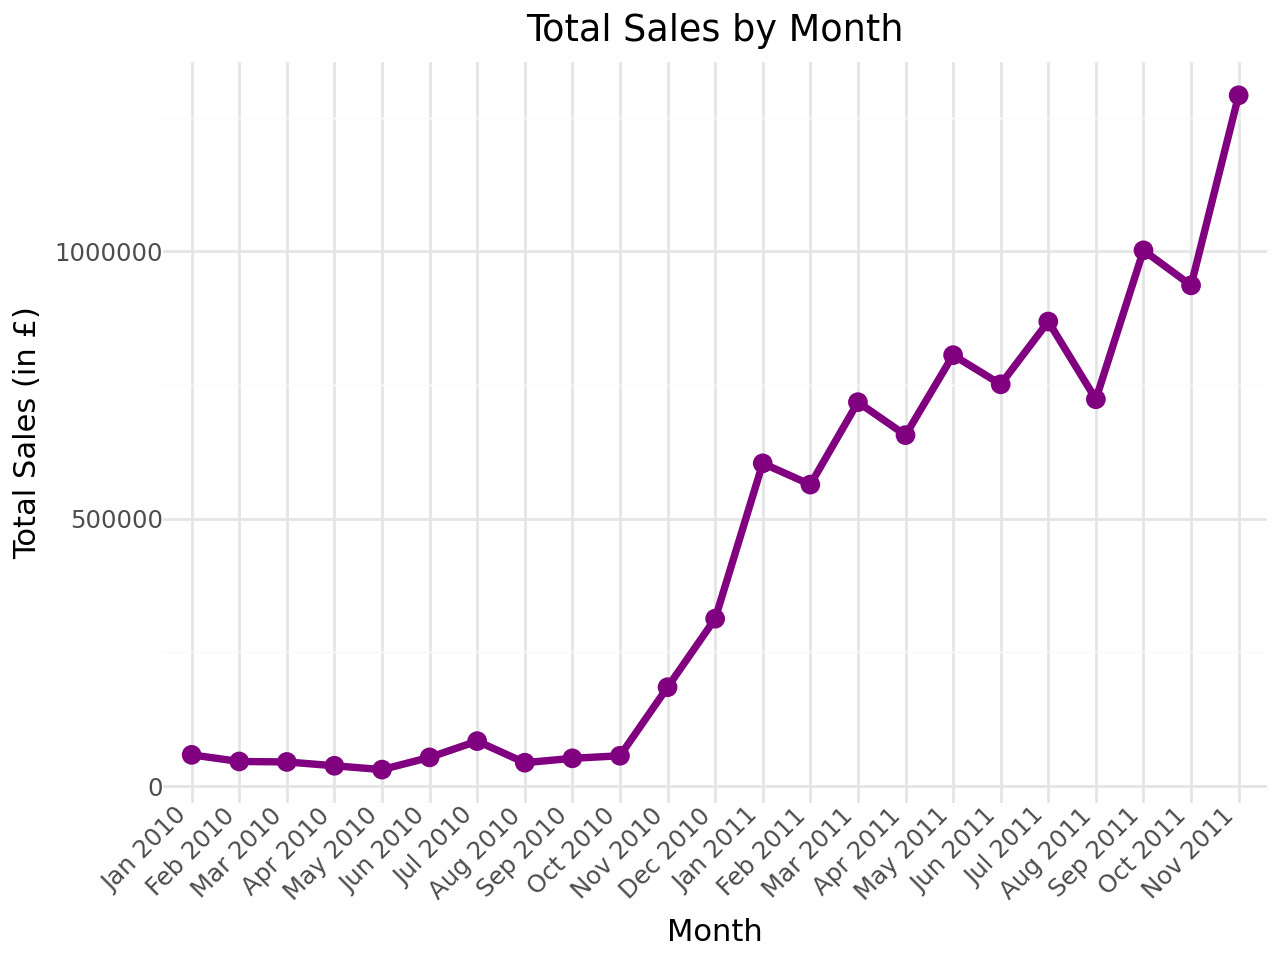

In [23]:
# Define the order of months as they appear in the DataFrame
month_order = sales['month'].tolist()

# Create line chart using Plotnine
line_chart = (
    ggplot(sales, aes(x='month', y='TotalSales', group='factor(month.str[:0])')) +  # Group by year
    geom_line(color='purple', size=1.5) +
    geom_point(color='purple', size=3) +
    labs(title="Total Sales by Month",
         x="Month",
         y="Total Sales (in £)") +
    theme_minimal() +
    theme(axis_text_x=element_text(angle=45, hjust=1)) +
    scale_x_discrete(limits=month_order)  # Set the order of x-axis ticks
)

line_chart.save("line_plot.jpg")
line_chart.show()

 ---
> ### **We can see upward trend with initial sharp increses towards the end of 2010 and the beginning of 2011.**
 ---

### *How Many Customers Purchased Products Each Month?*
### *How Many New Customers were There Each Month?*
- We saw some rows with missing CustomerIDs above, so first we check how many unique Invoices there are and how many of them have a missing CustomerID:

In [24]:
print(f"Unique customers who have visited: {len(data['InvoiceNo'].unique())}")

Unique customers who have visited: 23539


In [25]:
# invoices with at least one record with missing CustomerID
len(data[data["CustomerID"].isna()]["InvoiceNo"].unique())

1506

- We can also check how many invoices have all of their CustomerIDs missing.

In [26]:
data.groupby("InvoiceNo").apply(lambda x: all(np.isnan(i) for i in x["CustomerID"])).tolist().count(True)

1506

 ---
> As we see, the number is the same, which means that invoices either have missing values for all CustomerIDs, or no CustomerIDs are missing.
 ---
> Since we do not know how many customers have an NaN value for CustomerID, we drop records with missing CustomerIDs for this analysis.
 ---

In [27]:
customers = data[data["CustomerID"].notna()].groupby(["year", "month"]) \
.agg({"CustomerID": "unique"}) \
.reset_index().rename({"CustomerID": "unique_customer_ids"}, axis = 1)

# calculate the number of unique customers and insert it as a column
customers.insert(2,"unique_customers_this_month", customers["unique_customer_ids"].str.len())

customers.head()

year  month  unique_customers_this_month  \
0  2010      1                           98   
1  2010      2                          116   
2  2010      3                           55   
3  2010      5                           76   
4  2010      6                           90   

                                 unique_customer_ids  
0  [17850.0, 17511.0, 13408.0, 15862.0, 16552.0, ...  
1  [17850.0, 17732.0, 17976.0, 17685.0, 15640.0, ...  
2  [16883.0, 12841.0, 17967.0, 14723.0, 17198.0, ...  
3  [18055.0, 18109.0, 15708.0, 16931.0, 16814.0, ...  
4  [18219.0, 14748.0, 15860.0, 14344.0, 16719.0, ...

 ---
- New customers are customers who purchase an item for the first time. In other words, these are customers whose CustomerID appears in the records for the first time at the date of the purchase.
 ---
- To find which CustomerIDs appear for the first time, we create a running list which accumulates all unique_customer_ids up to each month. Then we remove duplicates and check the length of the list for each month. In doing so, we get the running total of unique customers.
 ---

In [28]:
ids = []

# creates a running list of customerids up to each month
for index, row in customers.iterrows(): 
    if index == 0:
        ids.append(row["unique_customer_ids"].tolist())
        
    else:   # adds the present ids to the accumulated list of previous ids
        ids.append(row["unique_customer_ids"].tolist() + ids[index-1])

In [29]:
total_customers = []
for i in range(len(ids)):
    total_customers.append(len(set(ids[i]))) # the set removes duplicates  
    
# insert as a column
customers.insert(3, "total_customers", total_customers)

In [30]:
customers.head(5)

year  month  unique_customers_this_month  total_customers  \
0  2010      1                           98               98   
1  2010      2                          116              205   
2  2010      3                           55              254   
3  2010      5                           76              322   
4  2010      6                           90              398   

                                 unique_customer_ids  
0  [17850.0, 17511.0, 13408.0, 15862.0, 16552.0, ...  
1  [17850.0, 17732.0, 17976.0, 17685.0, 15640.0, ...  
2  [16883.0, 12841.0, 17967.0, 14723.0, 17198.0, ...  
3  [18055.0, 18109.0, 15708.0, 16931.0, 16814.0, ...  
4  [18219.0, 14748.0, 15860.0, 14344.0, 16719.0, ...

In [31]:
# add the first difference of total_customers

customers.insert(3, "new_customers_this_month", customers["total_customers"].diff() \
.replace({np.nan: 98}).astype(int)) # fill in the first value

In [32]:
customers.head(5)

year  month  unique_customers_this_month  new_customers_this_month  \
0  2010      1                           98                        98   
1  2010      2                          116                       107   
2  2010      3                           55                        49   
3  2010      5                           76                        68   
4  2010      6                           90                        76   

   total_customers                                unique_customer_ids  
0               98  [17850.0, 17511.0, 13408.0, 15862.0, 16552.0, ...  
1              205  [17850.0, 17732.0, 17976.0, 17685.0, 15640.0, ...  
2              254  [16883.0, 12841.0, 17967.0, 14723.0, 17198.0, ...  
3              322  [18055.0, 18109.0, 15708.0, 16931.0, 16814.0, ...  
4              398  [18219.0, 14748.0, 15860.0, 14344.0, 16719.0, ...

In [33]:
 # drop the long lists of unique customers
customers = customers.drop("unique_customer_ids", axis = 1)

In [34]:
# create rows about April 2010 and November 2010 with averages from preceding and following months
new_rows = \
pd.DataFrame({"year":[2010,2010],
              "month": [4,11],
              "unique_customers_this_month": [65,271],
              "new_customers_this_month": [59,163],
              "total_customers": [288,803]}, index = [98,99]) # arbitrary indexes

# insert the row in the customers table
customers = pd.concat([new_rows, customers]) \
.sort_values(by=["year","month"]).reset_index(drop=True)

In [35]:
# convert numbers into month names
customers["month"] = customers["month"].apply(lambda x: calendar.month_abbr[x])

# combine month and year
customers["month"] = customers["month"].astype(str) + " " + customers["year"].astype(str)

# drop the redundant year column
customers = customers.drop("year", axis = 1)

customers = customers[0:23] # drop December 2011 since the data does not cover the whole month

In [36]:
customers.head()

month  unique_customers_this_month  new_customers_this_month  \
0  Jan 2010                           98                        98   
1  Feb 2010                          116                       107   
2  Mar 2010                           55                        49   
3  Apr 2010                           65                        59   
4  May 2010                           76                        68   

   total_customers  
0               98  
1              205  
2              254  
3              288  
4              322

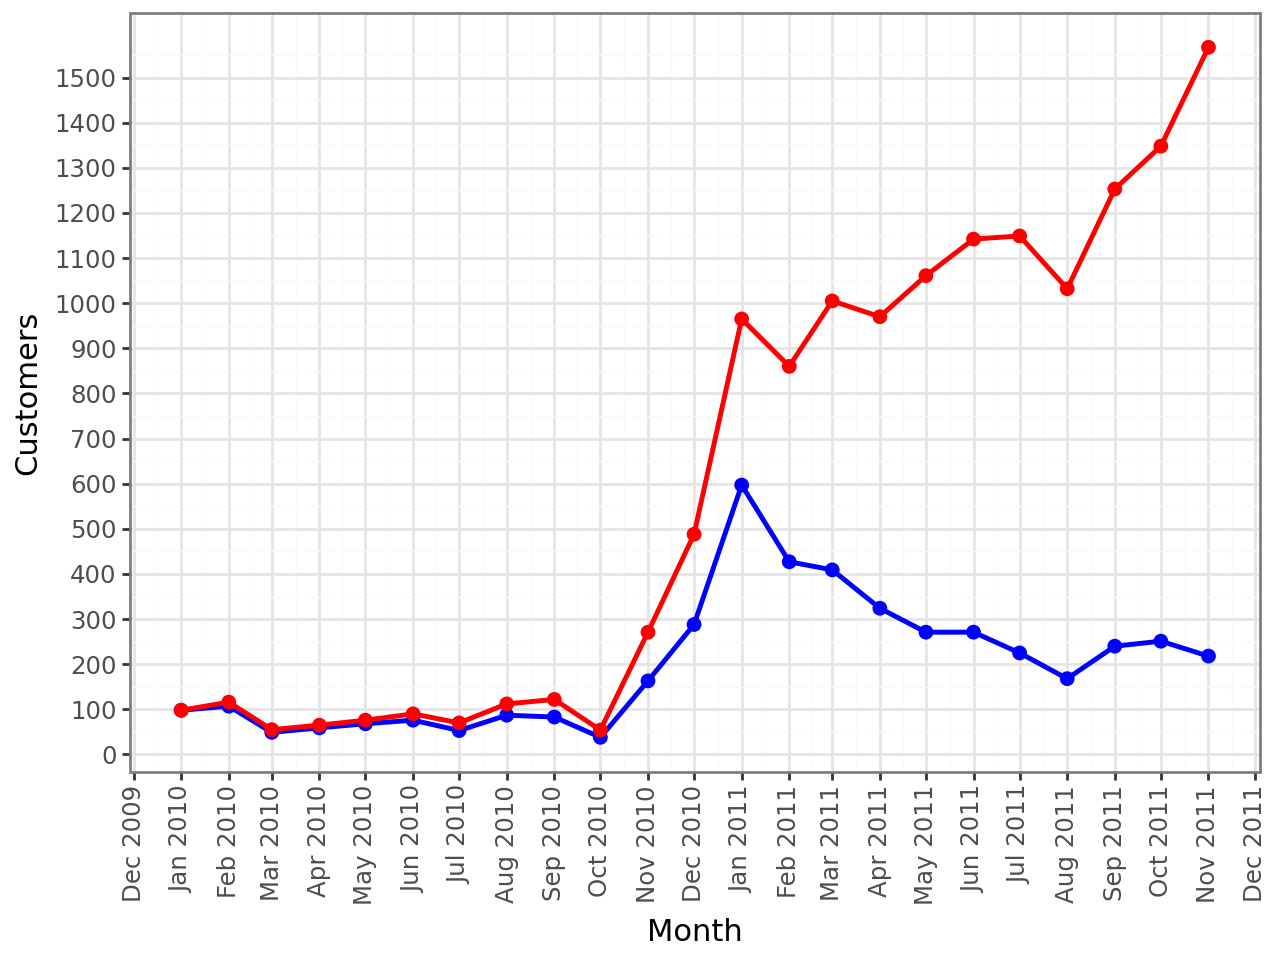

In [37]:
# Make a copy of customers DataFrame
customers_ = customers.copy()

# Convert "month" column to datetime type with specified format
customers_['month'] = pd.to_datetime(customers_['month'], format='%b %Y')

# Plot using Plotnine
(ggplot(customers_)
 + aes(x='month')
 + geom_line(aes(y='new_customers_this_month'), color='blue', size=1, show_legend=True)
 + geom_point(aes(y='new_customers_this_month'), color='blue', size=2)
 + geom_line(aes(y='unique_customers_this_month'), color='red', size=1, show_legend=True)
 + geom_point(aes(y='unique_customers_this_month'), color='red', size=2)
 + labs(x='Month', y='Customers', color='Plot')
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=90, hjust=0.5))
 + scale_x_datetime(date_breaks="1 month", date_labels="%b %Y")  
 + scale_y_continuous(breaks=range(0, max(customers_['unique_customers_this_month'])+1, 100)) 
 + scale_color_manual(values=["blue", "red"], labels=["New Customers", "Unique Customers"])
)

- **As plotnine only show static plots so we can use plotly to make the above plot interactive.**

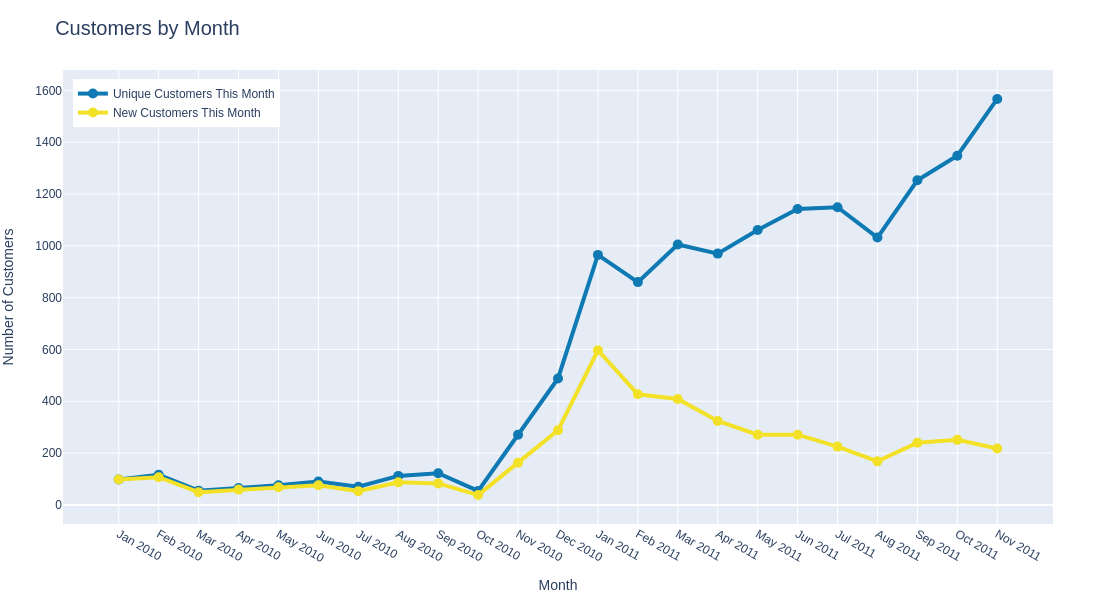

In [38]:
trace1 = go.Scatter(
                    x = customers["month"],
                    y = customers["unique_customers_this_month"],
                    mode = "lines+markers",
                    name = "Unique Customers This Month",
                    line = dict(width = 4),
                    marker = dict(
                                  size = 10,
                                  color = "#0E79B2"
                                 ),
                    hovertemplate = "%{x}<br>Unique Customers: %{y} <extra></extra>",
                  )
trace2 = go.Scatter(
                    x = customers["month"],
                    y = customers["new_customers_this_month"],
                    mode = "lines+markers",
                    name = "New Customers This Month",
                    line = dict(width = 4),
                    marker = dict(
                                  size = 10,
                                  color = "rgba(242, 225, 39, 1)"
                                 ),
                    hovertemplate = "%{x}<br>New Customers: %{y} <extra></extra>",
                  )

line_data = [trace1, trace2]

layout = dict(
              title = "Customers by Month",
              titlefont = dict(size = 20),
              margin=dict(l=10, r=50, b=10, t=70, pad=0),
              xaxis= dict(title= "Month",ticklen = 5,zeroline = False),
              yaxis= dict(title= "Number of Customers"),
              width=900,  
              height=600,
              legend=dict(
                          font = dict(size = 12),
                          yanchor = "top",
                          y=0.98,
                          x= 0.01
                         )
             )
fig = dict(data = line_data, layout = layout)

# Save the animation as an HTML file
plot(fig, filename='Unique Customers each month.html', auto_open=False)

iplot(fig)


 ---
> **We can see a significant jump in new customers around December 2010 and January 2011, likely related to the Christmas holidays.**  
 ---
> **We can see another spike in customers in November 2011, although there is no spike in new customers. This might suggest that customers were satisfied with their Christmas purchases in 2010, and are now coming back to the online store for their Christmas 2011 purchases.**
 ---
> **We do see that the number of new customers has been decreasing slowly over the year. This could once again be related to marketing campaigns and could be investigated.**
 ---

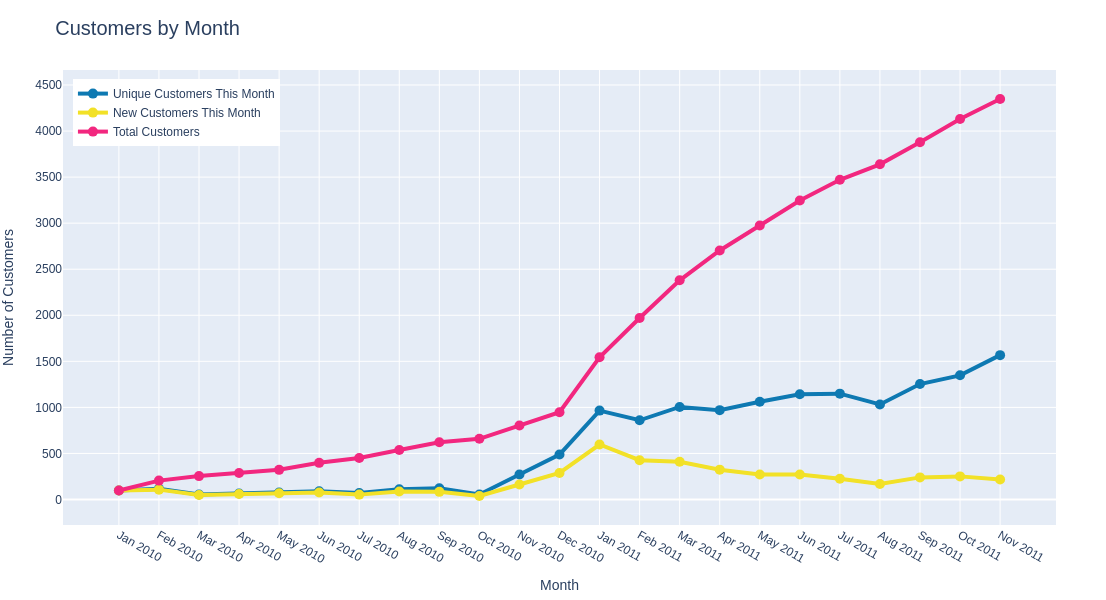

In [39]:
trace1 = go.Scatter(
                    x = customers["month"],
                    y = customers["unique_customers_this_month"],
                    mode = "lines+markers",
                    name = "Unique Customers This Month",
                    line = dict(width = 4),
                    marker = dict(
                                  size = 10,
                                  color = "#0E79B2"
                                 ),
                    hovertemplate = "%{x}<br>Unique Customers: %{y} <extra></extra>",
                  )
trace2 = go.Scatter(
                    x = customers["month"],
                    y = customers["new_customers_this_month"],
                    mode = "lines+markers",
                    name = "New Customers This Month",
                    line = dict(width = 4),
                    marker = dict(
                                  size = 10,
                                  color = "rgba(242, 225, 39, 1)"
                                 ),
                    hovertemplate = "%{x}<br>New Customers: %{y} <extra></extra>",
                  )
trace3 = go.Scatter(
                    x = customers["month"],
                    y = customers["total_customers"],
                    mode = "lines+markers",
                    name = "Total Customers",
                    line = dict(width = 4), 
                    marker = dict(
                                  size = 10,
                                  color = "rgba(242, 39, 127, 1)"
                                 ),
                    hovertemplate = "%{x}<br>Total Customers: %{y} <extra></extra>",
                  )

line_data = [trace1, trace2, trace3]

layout = dict(
              title = "Customers by Month",
              titlefont = dict(size = 20),
              margin=dict(l=10, r=50, b=10, t=70, pad=0),
              xaxis= dict(title= "Month",ticklen = 5,zeroline = False),
              yaxis= dict(title= "Number of Customers"),
              width=900,  
              height=600,
              legend=dict(
                          font = dict(size = 12),
                          yanchor = "top",
                          y=0.98,
                          x= 0.01
                         )
             )
fig = dict(data = line_data, layout = layout)

# Save the animation as an HTML file
plot(fig, filename='total Customers each month.html', auto_open=False)

iplot(fig)

 ---
> **We do infact see that the line chart of the number of total customers has a concave shape. In other words, the number of total customers is increasing at a descreasing rate. As commented above, this is directly related to the decreasing number of new customers.**
 ---

### **What Time During the Day Do Customers Make the Most Purchases?**

- We have seen spikes in sales around December 2010, which is likely related to the Christmas holidays. Since the last date of this dataset is December 2011 (which we assume is the present), we expect that the business would be running marketing campaigns for this year's Christmas hodidays as well. Therefore, it would be useful to find out what time of day customers make the most purchases in order to target the marketing campaigns around these times.

- To check this, we can look at what time customers were making the most orders the previous December (i.e. December 2010), as well as the most common hours for purchases during the last 2 months (i.e. October and November 2011). Since we have data about 12 days of December 2011, we include these in the analysis as well.

In [40]:
# take data only about December 2010 and October, Novermber and December 2011
subset = data[
              ((data["year"] == 2010) & (data["month"] == 12))
              |    
              ((data["year"] == 2011) & (data["month"] == 10))
              |
              ((data["year"] == 2011) & (data["month"] == 11))
              |
              ((data["year"] == 2011) & (data["month"] == 12))
              ]

In [41]:
# extract the hour of purchase from InvoiceDate and add it as a column
subset["hour"] = subset["InvoiceDate"].astype(str).str[11:13].astype(int)

In [42]:
# calculate the total number of orders for each hour of the day in these months

frequency = subset.groupby(["year","month","hour"]) \
.agg({"InvoiceNo":"nunique"}).reset_index() \
.rename({"InvoiceNo": "num_orders"}, axis = 1)

frequency.head()

year  month  hour  num_orders
0  2010     12     8           7
1  2010     12     9          51
2  2010     12    10          87
3  2010     12    11         127
4  2010     12    12         106

>We pivot the table, so it is easier to read and easier to plot:

In [43]:
pivot = frequency.pivot(index = "hour", columns = ["year","month"], values = ["num_orders"])

pivot = pd.DataFrame(pivot.to_records()) # flattens multilevel column headings

pivot["hour"] = pivot["hour"].astype(str) + ":00" # make hours more readable

pivot = pivot.set_index("hour")

pivot.index.name = "" # remove index name for plotting

pivot.rename(columns={ # set more readable names
                      pivot.columns[0]:"Dec 2010",
                      pivot.columns[1]:"Oct 2011",
                      pivot.columns[2]:"Nov 2011",
                      pivot.columns[3]:"Dec 2011"
                      }, inplace = True)

pivot

Dec 2010  Oct 2011  Nov 2011  Dec 2011
                                             
7:00        NaN       5.0       2.0       NaN
8:00        7.0      52.0     111.0      10.0
9:00       51.0     123.0     201.0      56.0
10:00      87.0     253.0     301.0      61.0
11:00     127.0     257.0     343.0      74.0
12:00     106.0     368.0     423.0      92.0
13:00     112.0     317.0     401.0      77.0
14:00      93.0     289.0     335.0      62.0
15:00     118.0     252.0     318.0      59.0
16:00      70.0     163.0     239.0      42.0
17:00      41.0      77.0     113.0      17.0
18:00       6.0      13.0      10.0      15.0
19:00       8.0      23.0       8.0      17.0
20:00       NaN       4.0       1.0       2.0

- **And we will plot a heatmap of these values for each month:**
### `Used faceting`

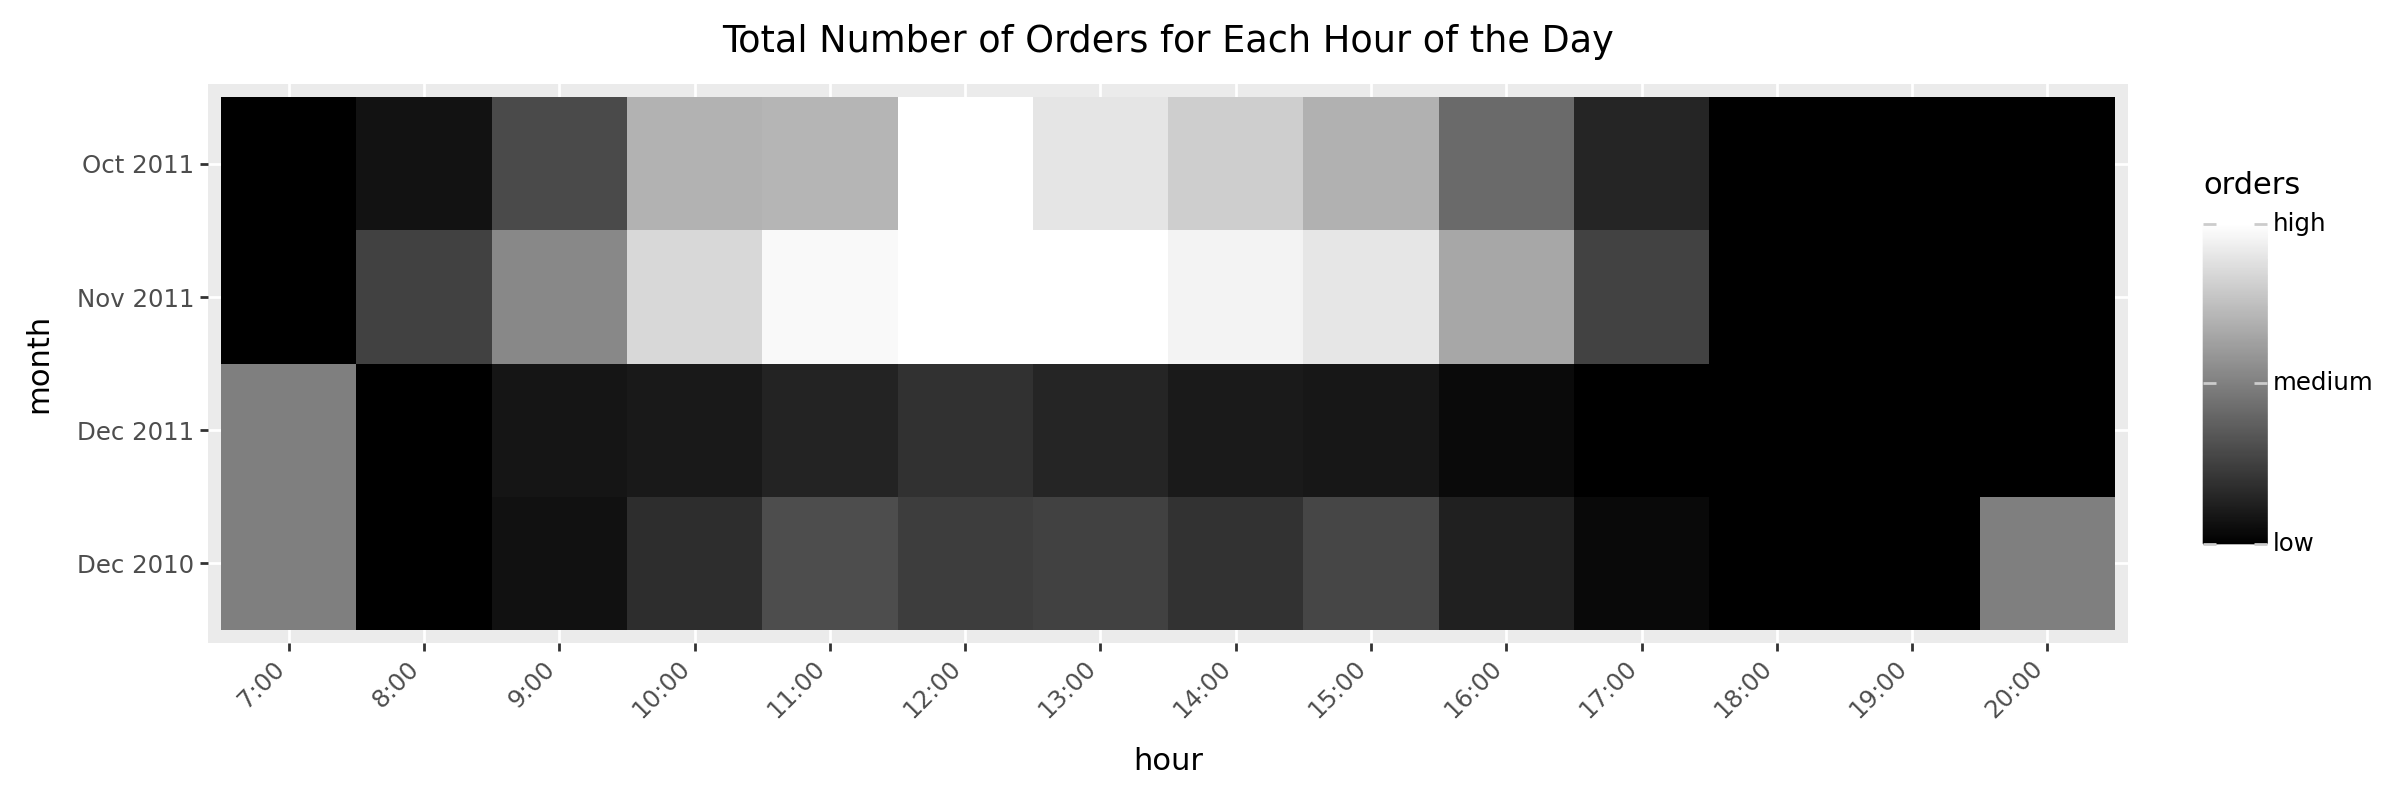

In [44]:
# Transpose the DataFrame to have hours as rows and months as columns
pivot_transposed = pivot.T.reset_index()

# Rename the columns to match the required format
pivot_transposed.columns = ['month', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00']

# Melt the DataFrame to long format
melted_df = pivot_transposed.melt(id_vars=['month'], var_name='hour', value_name='orders')

# Convert hour to categorical to maintain the order
melted_df['hour'] = pd.Categorical(melted_df['hour'], categories=['7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00'])

# Plot the heatmap
heatmap = (
    ggplot(melted_df, aes(x='hour', y='month', fill='orders'))
    + geom_tile()
    + scale_fill_gradient(low="black", high="white", limits=[30, 350], breaks=[30, 190, 350], labels=["low", "medium", "high"])
    + theme(axis_text_x=element_text(angle=45, hjust=1),
           figure_size=(12, 4))
    + ggtitle("Total Number of Orders for Each Hour of the Day")
)

# Show the heatmap
print(heatmap)

In [46]:
# Apply styling
styled_df = pivot.replace(np.nan, 0).style \
    .background_gradient(cmap="rocket", subset=["Dec 2010"]) \
    .background_gradient(cmap="rocket", subset=["Oct 2011"]) \
    .background_gradient(cmap="rocket", subset=["Nov 2011"]) \
    .background_gradient(cmap="rocket", subset=["Dec 2011"]) \
    .format("{:.0f}")

# Convert styled DataFrame to HTML and save to a file
styled_df.to_html("heatmap_table.html", escape=False)

In [47]:
styled_df

> **From these figures, it is clear that the most orders are placed around midday, more specifically at 12:00. Therefore, the marketing team could target their campaigns around these times to maximize conversions.**

### **Which is the Best Selling Product in Each Country?**
- **Now, we'll investigate which product generated the highest sales in each country, how much sales it generated, and what percent of the country's total sales it generated. We also find which product is the most common best seller.**

In [48]:
# calculate total sales for each product in each country
sales_countr_descr = data.groupby(["Country", "Description"]) \
.agg({"ItemTotal": "sum"}) \
.rename({"ItemTotal":"TotalSales"},axis=1).reset_index()

sales_countr_descr

Country                         Description  TotalSales
0        Australia              10 COLOUR SPACEBOY PEN        40.8
1        Australia       12 PENCIL SMALL TUBE WOODLAND       211.2
2        Australia           12 PENCILS TALL TUBE POSY        79.8
3        Australia  12 PENCILS TALL TUBE RED RETROSPOT        10.2
4        Australia  16 PIECE CUTLERY SET PANTRY DESIGN       300.0
...            ...                                 ...         ...
19505  Unspecified               WRAP SUKI AND FRIENDS        10.5
19506  Unspecified         WRAP VINTAGE PETALS  DESIGN        10.5
19507  Unspecified                    WRAP WEDDING DAY        10.5
19508  Unspecified        WRAP, BILLBOARD FONTS DESIGN        10.5
19509  Unspecified         ZINC METAL HEART DECORATION         2.5

[19510 rows x 3 columns]

In [49]:
# find the total sales of the best selling product in each country
max_sales = pd.DataFrame(sales_countr_descr.groupby("Country") \
["TotalSales"].max().reset_index()) \
.rename({"TotalSales":"Best_Product_Total_Sales"},axis=1)

max_sales.head()

Country  Best_Product_Total_Sales
0  Australia                   3375.84
1    Austria                    302.40
2    Bahrain                    120.00
3    Belgium                   1181.40
4     Brazil                    175.20

In [50]:
# join the two tables from above together
joined_df = sales_countr_descr.merge(max_sales, on = "Country", how = "left")
joined_df

Country                         Description  TotalSales  \
0        Australia              10 COLOUR SPACEBOY PEN        40.8   
1        Australia       12 PENCIL SMALL TUBE WOODLAND       211.2   
2        Australia           12 PENCILS TALL TUBE POSY        79.8   
3        Australia  12 PENCILS TALL TUBE RED RETROSPOT        10.2   
4        Australia  16 PIECE CUTLERY SET PANTRY DESIGN       300.0   
...            ...                                 ...         ...   
19505  Unspecified               WRAP SUKI AND FRIENDS        10.5   
19506  Unspecified         WRAP VINTAGE PETALS  DESIGN        10.5   
19507  Unspecified                    WRAP WEDDING DAY        10.5   
19508  Unspecified        WRAP, BILLBOARD FONTS DESIGN        10.5   
19509  Unspecified         ZINC METAL HEART DECORATION         2.5   

       Best_Product_Total_Sales  
0                       3375.84  
1                       3375.84  
2                       3375.84  
3                       3375.84  
4                       3375.84  
...                         ...  
19505                     70.50  
19506                     70.50  
19507                     70.50  
19508                     70.50  
19509                     70.50  

[19510 rows x 4 columns]

In [51]:
# find the products whose sales equal the highest product sales in each country
# in other words, find the best selling item in each country
joined_df = joined_df[joined_df["TotalSales"] == joined_df["Best_Product_Total_Sales"]]
joined_df.head()

Country                         Description  TotalSales  \
371   Australia                  RABBIT NIGHT LIGHT     3375.84   
770     Austria      PACK OF 6 PANNETONE GIFT BOXES      302.40   
773     Austria        PACK OF 6 SWEETIE GIFT BOXES      302.40   
909     Bahrain          ICE CREAM SUNDAE LIP GLOSS      120.00   
1475    Belgium  ROUND SNACK BOXES SET OF4 WOODLAND     1181.40   

      Best_Product_Total_Sales  
371                    3375.84  
770                     302.40  
773                     302.40  
909                     120.00  
1475                   1181.40

In [52]:
# drop the redundant column
joined_df = joined_df.drop("Best_Product_Total_Sales", axis = 1)

- *Now we want to find the percentage of total sales these products have generated in each country. To do this we create a table with the countries' total sales and join it to the table above:*

In [53]:
# total sales in each country
country_sales = pd.DataFrame(data.groupby("Country")["ItemTotal"].sum()) \
.reset_index().rename({"ItemTotal":"Country_Total_Sales"}, axis = 1)

country_sales.head()

Country  Country_Total_Sales
0  Australia            136990.00
1    Austria              8698.32
2    Bahrain               548.40
3    Belgium             36662.96
4     Brazil              1143.60

In [54]:
joined_df = joined_df.merge(country_sales, on = "Country", how = "inner") \
.rename({"Description":"Best_Selling_Product"}, axis = 1)

joined_df.head()

Country                Best_Selling_Product  TotalSales  \
0  Australia                  RABBIT NIGHT LIGHT     3375.84   
1    Austria      PACK OF 6 PANNETONE GIFT BOXES      302.40   
2    Austria        PACK OF 6 SWEETIE GIFT BOXES      302.40   
3    Bahrain          ICE CREAM SUNDAE LIP GLOSS      120.00   
4    Belgium  ROUND SNACK BOXES SET OF4 WOODLAND     1181.40   

   Country_Total_Sales  
0            136990.00  
1              8698.32  
2              8698.32  
3               548.40  
4             36662.96

- *And add another column calculating the percentage of total sales which the Best selling items has generated in each country. It is formatted as a percentage with 2 decimal points. A background gradient is applied.*

In [55]:
joined_df["%_of_Country_Sales"] = (joined_df["TotalSales"] / joined_df["Country_Total_Sales"])

styled_df = joined_df.style.background_gradient(cmap=sns.light_palette("seagreen", as_cmap=True), \
    subset=["%_of_Country_Sales"]) \
    .format({"%_of_Country_Sales":"{:.2%}",
             "TotalSales":"£{:,.0f}",
             "Country_Total_Sales":"£{:,.0f}"})
styled_df

In [56]:
# Convert styled DataFrame to HTML and save to a file
styled_df.to_html("styled_table.html", escape=False)

### **Which product is the most common best seller?**

In [57]:
df_ = pd.DataFrame(joined_df["Best_Selling_Product"].value_counts()) \
.rename({"Best_Selling_Product":"Best_Selling_Product_in_X_Countries"},axis=1)
df_.to_html("most common product.html", escape=False)

In [58]:
df_

count
Best_Selling_Product                      
REGENCY CAKESTAND 3 TIER                 8
RABBIT NIGHT LIGHT                       4
ROUND SNACK BOXES SET OF4 WOODLAND       3
PINK 3 PIECE POLKADOT CUTLERY SET        3
RETROSPOT TEA SET CERAMIC 11 PC          2
ICE CREAM SUNDAE LIP GLOSS               1
RETRO COFFEE MUGS ASSORTED               1
DOTCOM                                   1
SET 6 SCHOOL MILK BOTTLES IN CRATE       1
MINI PAINT SET VINTAGE                   1
DOORMAT UNION FLAG                       1
PLASTERS IN TIN STRONGMAN                1
PLASTERS IN TIN SKULLS                   1
PLASTERS IN TIN CIRCUS PARADE            1
CLASSIC METAL BIRDCAGE PLANT HOLDER      1
STRAWBERRY CERAMIC TRINKET BOX           1
GROW A FLYTRAP OR SUNFLOWER IN TIN       1
GRAND CHOCOLATECANDLE                    1
GREY FLORAL FELTCRAFT SHOULDER BAG       1
PACK OF 6 PANNETONE GIFT BOXES           1
3D DOG PICTURE PLAYING CARDS             1
PACK OF 6 SWEETIE GIFT BOXES             1
BISCUIT TIN VINTAGE RED                  1
BISCUIT TIN VINTAGE GREEN                1
RED KITCHEN SCALES                       1
RUSTIC  SEVENTEEN DRAWER SIDEBOARD       1
JAM MAKING SET WITH JARS                 1

### **Which are the Most Successful Products Overall?**
- *A characteristic we could use to answer this is: which products of relatively high price have sold relatively high quantities. This can be easily visualized with a scatter plot of all products with total quantity sold and average unitprice on the x and y axes.*

- *Products' markers to the north-east on the scatter plot suggest relatively high quantities sold at a relatively high price.*

In [91]:
# find total quantity sold and average unit price for all products
products = data.groupby("Description") \
.agg({"Quantity":"sum", "UnitPrice":"mean"}).reset_index()

products = products[products["Description"].isin(["DOTCOM","Manual","Discount"]) == False] # remove for plotting

products

Description  Quantity  UnitPrice
0                *Boombox Ipod Classic         1  16.980000
1              *USB Office Mirror Ball         2   8.470000
2               10 COLOUR SPACEBOY PEN      6392   1.050917
3           12 COLOURED PARTY BALLOONS      2135   0.703000
4            12 DAISY PEGS IN WOOD BOX       349   1.907143
...                                ...       ...        ...
3782   ZINC T-LIGHT HOLDER STARS SMALL      5045   0.942446
3783     ZINC TOP  2 DOOR WOODEN SHELF         8  20.359286
3784  ZINC WILLIE WINKIE  CANDLE STICK      2922   1.089084
3785       ZINC WIRE KITCHEN ORGANISER        30   9.929375
3786  ZINC WIRE SWEETHEART LETTER TRAY        83   3.976522

[3784 rows x 3 columns]

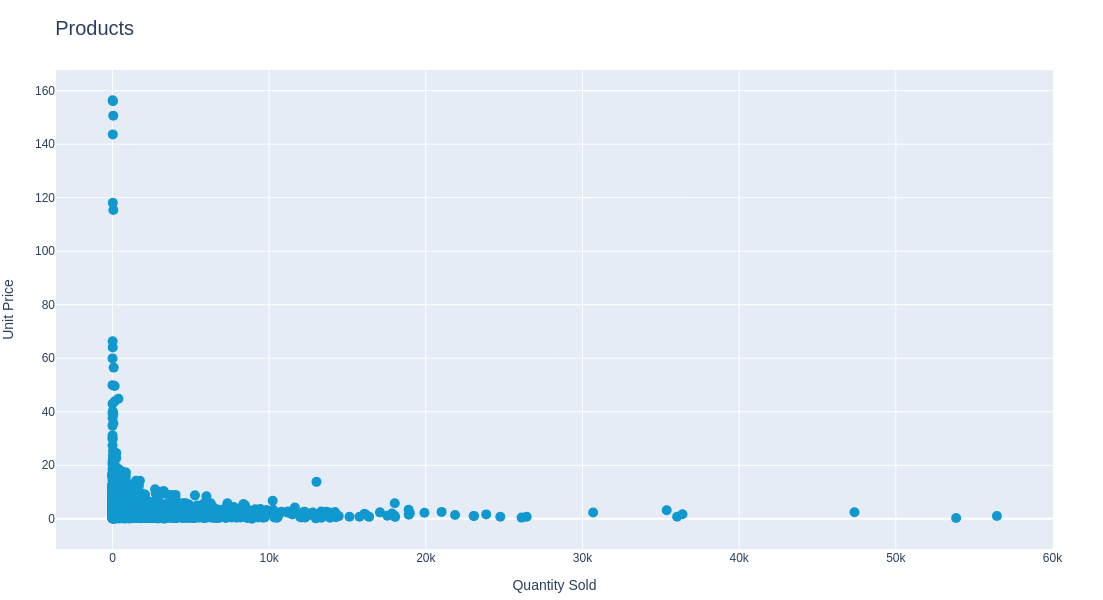

In [92]:
trace = go.Scatter(
                    x = products["Quantity"],
                    y = products["UnitPrice"],
                    customdata = products["Description"],
                    hovertemplate = "%{customdata}<br>Quantity Sold: %{x}<br>UnitPrice: £%{y:.2f}<br><extra></extra>",
                    mode = "markers",
                    name = "Products",
                    line = dict(width = 4),
                    marker = dict(
                                  size = 10,
                                  color = "#1199cf"
                                 )
                    )

scatter_data = [trace]

layout = dict(
              title = "Products",
              titlefont = dict(size = 20),
              margin=dict(l=10, r=50, b=10, t=70, pad=0),
              xaxis= dict(title= "Quantity Sold",ticklen = 5,zeroline = False),
              width=1000,  
              height=600,
              yaxis= dict(title= "Unit Price")
             )
fig = dict(data = scatter_data, layout = layout)

# Save the animation as an HTML file
plot(fig, filename='most successful product overall', auto_open=False)

iplot(fig)


## Using plotnine

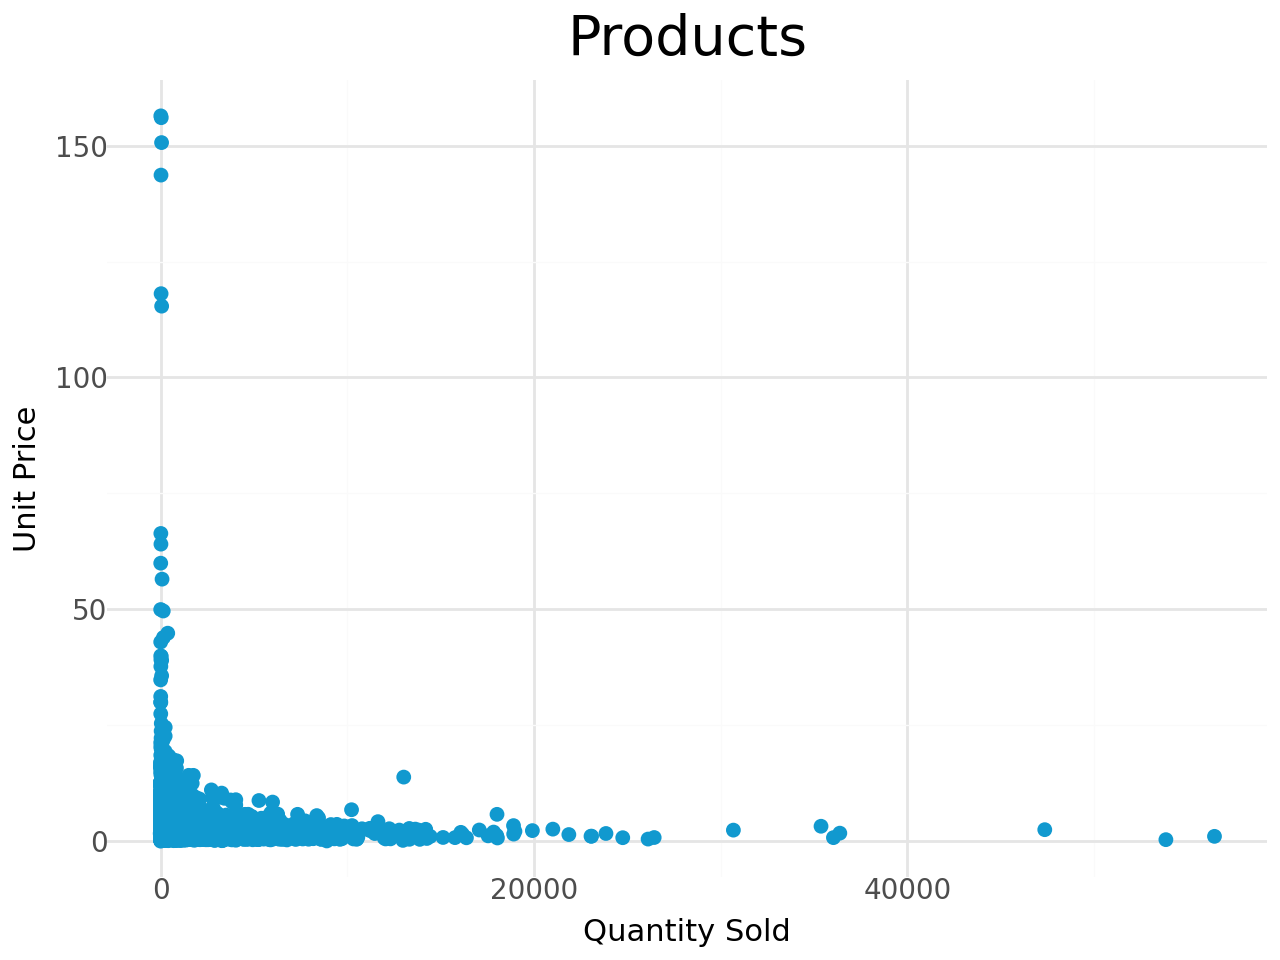

In [61]:
# Create a new DataFrame for tooltips
tooltip_df = products[['Description', 'Quantity', 'UnitPrice']]

# Define the plot
scatter_plot = (
    ggplot(products, aes(x='Quantity', y='UnitPrice')) +
    geom_point(size=2, color="#1199cf") +
    labs(title="Products", x="Quantity Sold", y="Unit Price") +
    theme_minimal() +
    theme(
        plot_title=element_text(size=20),
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10)
    )
)

scatter_plot

> *Above we saw "REGENCY CAKESTAND 3 TIER" as the most common best seller (8 countries) and here we see it as a high selling product as well - its marker is visually separated from the other products on the plot.*

### **Which Customers Contributed the Most to Total Sales?**
- *Finally, let's see the customers with highest purchase figures and their corresponding number of orders:*

In [62]:
cust_purchases = \
data.groupby("CustomerID") \
.agg({"InvoiceNo": "nunique", "ItemTotal": "sum"}) \
.rename({"ItemTotal":"TotalPurchases","InvoiceNo":"Number_of_Orders"},axis = 1) \
.sort_values(by = "TotalPurchases", ascending = False)

cust_purchases.head(15) # only first 15

Number_of_Orders  TotalPurchases
CustomerID                                  
14646.0                   74       278466.02
18102.0                   62       256438.49
17450.0                   51       188420.57
14911.0                  247       132572.62
12415.0                   24       123638.18
14156.0                   66       113384.14
17511.0                   45        88127.55
16684.0                   31        65892.08
14096.0                   18        65054.34
13694.0                   60        62653.10
15311.0                  118        59419.34
13089.0                  118        57385.88
15061.0                   55        54228.74
17949.0                   52        52750.84
15769.0                   29        51823.72

In [63]:
# Select the first 15 rows of the DataFrame
cust_purchases_subset = cust_purchases.head(15)

In [64]:

# Export the selected rows to HTML
cust_purchases_subset.to_html("most_contribution_of_customer.html", escape=False)

### **How much did each customer contribute to the total sales figure in percentage terms?**

In [65]:
cust_purchases["Percent_of_TotalSales"] = (cust_purchases["TotalPurchases"]/data["ItemTotal"].sum()).map("{:.2%}".format)
cust_purchases["TotalPurchases"] = cust_purchases["TotalPurchases"].map("£{:,.0f}".format) # format as currency

cust_purchases.head(15) # first 15 only

Number_of_Orders TotalPurchases Percent_of_TotalSales
CustomerID                                                       
14646.0                   74       £278,466                 2.80%
18102.0                   62       £256,438                 2.58%
17450.0                   51       £188,421                 1.90%
14911.0                  247       £132,573                 1.33%
12415.0                   24       £123,638                 1.24%
14156.0                   66       £113,384                 1.14%
17511.0                   45        £88,128                 0.89%
16684.0                   31        £65,892                 0.66%
14096.0                   18        £65,054                 0.66%
13694.0                   60        £62,653                 0.63%
15311.0                  118        £59,419                 0.60%
13089.0                  118        £57,386                 0.58%
15061.0                   55        £54,229                 0.55%
17949.0                   52        £52,751                 0.53%
15769.0                   29        £51,824                 0.52%

In [ ]:
# Select the first 15 rows of the DataFrame
cust_purchases_subset = cust_purchases.head(15)

# Export the selected rows to HTML
cust_purchases_subset.to_html("most_contribution_of_customer_in_percentage.html", escape=False)

### *We saw that the sales were increasing at relatively larger rate during october 2010 to january 2011 , Now we'll see that which product has made larger cotribution during this interval.*

In [76]:
data.head()

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536373    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
2    536375    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
3    536390    85123A  WHITE HANGING HEART T-LIGHT HOLDER        64   
4    536394    85123A  WHITE HANGING HEART T-LIGHT HOLDER        32   

          InvoiceDate  UnitPrice  CustomerID         Country  ItemTotal  year  \
0 2010-01-12 08:26:00       2.55     17850.0  United Kingdom       15.3  2010   
1 2010-01-12 09:02:00       2.55     17850.0  United Kingdom       15.3  2010   
2 2010-01-12 09:32:00       2.55     17850.0  United Kingdom       15.3  2010   
3 2010-01-12 10:19:00       2.55     17511.0  United Kingdom      163.2  2010   
4 2010-01-12 10:39:00       2.55     13408.0  United Kingdom       81.6  2010   

   month  
0      1  
1      1  
2      1  
3      1  
4      1

In [77]:
# Step 1: Filter the dataframe
filtered_data = data[(data['year'] == 2010) & (data['month'] >= 10) | (data['year'] == 2011) & (data['month'] <= 1)]

In [78]:
filtered_data.head()

InvoiceNo StockCode                         Description  Quantity  \
118    538176    85123A  WHITE HANGING HEART T-LIGHT HOLDER        64   
119    538177    85123A  WHITE HANGING HEART T-LIGHT HOLDER         1   
120    538182    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
121    538186    85123A  WHITE HANGING HEART T-LIGHT HOLDER        12   
122    538190    85123A  WHITE HANGING HEART T-LIGHT HOLDER         5   

            InvoiceDate  UnitPrice  CustomerID         Country  ItemTotal  \
118 2010-10-12 09:48:00       2.55     17675.0  United Kingdom     163.20   
119 2010-10-12 09:51:00       5.91         NaN  United Kingdom       5.91   
120 2010-10-12 10:18:00       2.95     17827.0  United Kingdom      17.70   
121 2010-10-12 10:26:00       2.95     13000.0  United Kingdom      35.40   
122 2010-10-12 10:47:00       2.95     17790.0  United Kingdom      14.75   

     year  month  
118  2010     10  
119  2010     10  
120  2010     10  
121  2010     10  
122  2010     10

In [83]:
# find total quantity sold and average unit price for all products
products1 = filtered_data.groupby("Description") \
.agg({"Quantity":"sum", "UnitPrice":"mean"}).reset_index()

products1 = products1[products1["Description"].isin(["DOTCOM","Manual","Discount"]) == False] # remove for plotting

products1

Description  Quantity  UnitPrice
0              *USB Office Mirror Ball         2   8.470000
1               10 COLOUR SPACEBOY PEN       342   1.094242
2           12 COLOURED PARTY BALLOONS       217   0.744615
3            12 DAISY PEGS IN WOOD BOX        98   1.826316
4            12 EGG HOUSE PAINTED WOOD        26  18.323889
...                                ...       ...        ...
3268    ZINC T-LIGHT HOLDER STAR LARGE        83   1.088571
3269   ZINC T-LIGHT HOLDER STARS SMALL       149   0.899000
3270     ZINC TOP  2 DOOR WOODEN SHELF         4  29.382500
3271  ZINC WILLIE WINKIE  CANDLE STICK       267   1.175556
3272       ZINC WIRE KITCHEN ORGANISER         1  10.400000

[3270 rows x 3 columns]

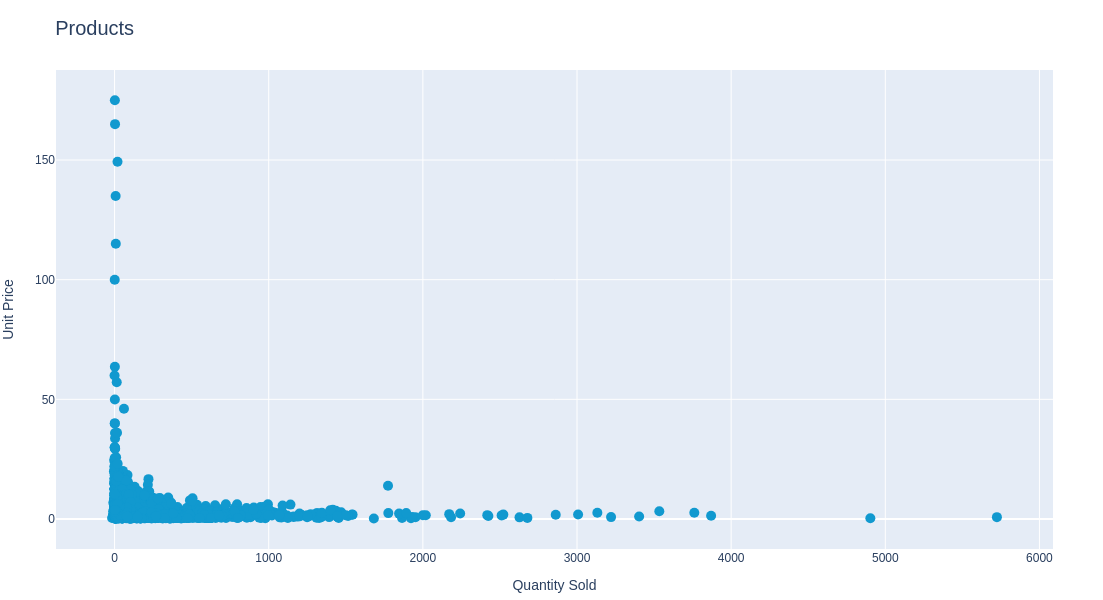

In [95]:
trace = go.Scatter(
                    x = products1["Quantity"],
                    y = products1["UnitPrice"],
                    customdata = products1["Description"],
                    hovertemplate = "%{customdata}<br>Quantity Sold: %{x}<br>UnitPrice: £%{y:.2f}<br><extra></extra>",
                    mode = "markers",
                    name = "Products",
                    line = dict(width = 4),
                    marker = dict(
                                  size = 10,
                                  color = "#1199cf"
                                 )
                    )

scatter_data = [trace]

layout = dict(
              title = "Products",
              titlefont = dict(size = 20),
              margin=dict(l=10, r=50, b=10, t=70, pad=0),
              xaxis= dict(title= "Quantity Sold",ticklen = 5,zeroline = False),
              width=1000,  
              height=600,
              yaxis= dict(title= "Unit Price")
             )
fig = dict(data = scatter_data, layout = layout)

# Save the animation as an HTML file
plot(fig, filename='most successful product overall2', auto_open=False)

iplot(fig)


### plotline code

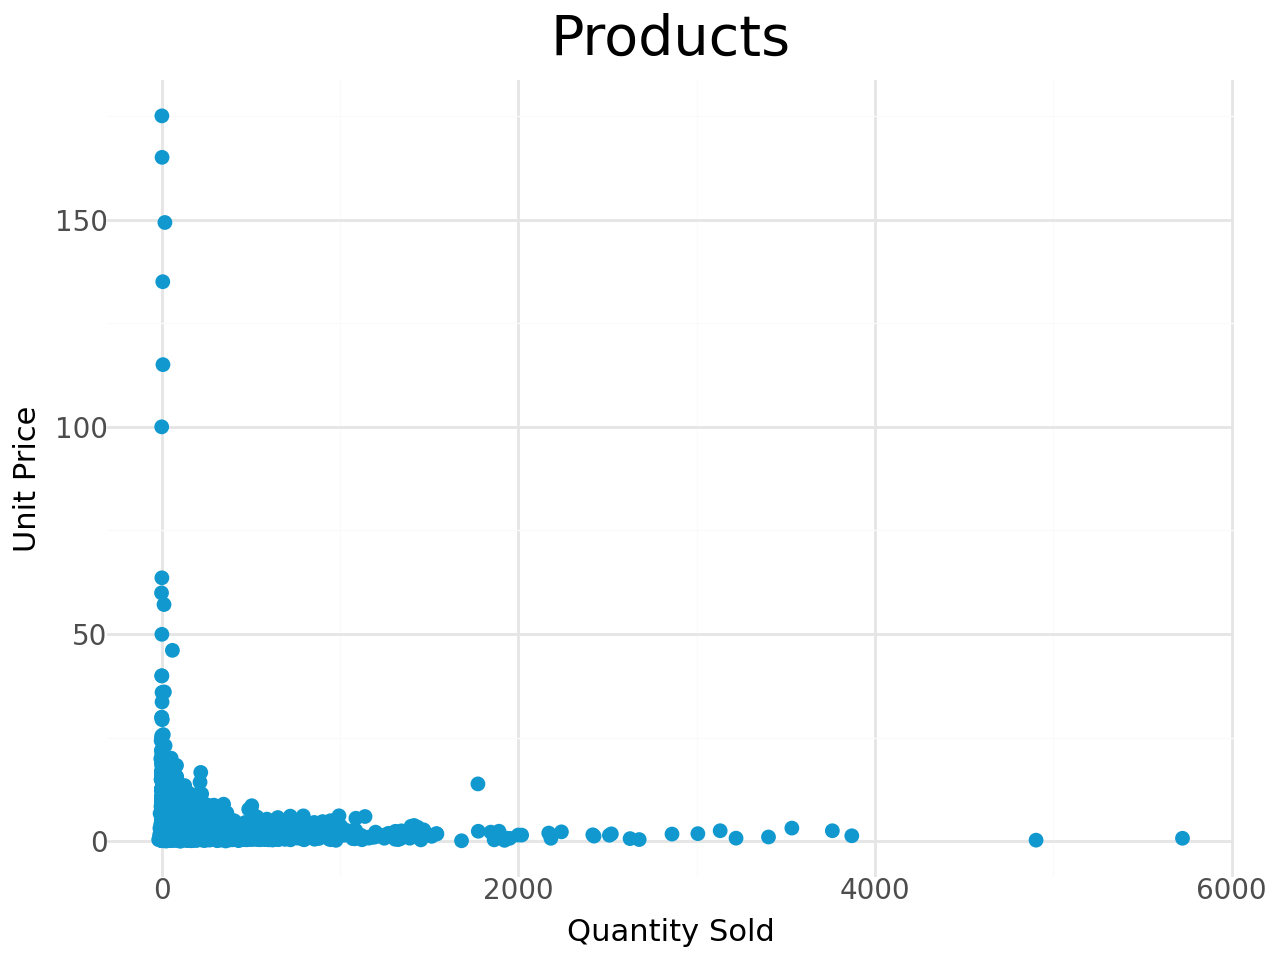

In [110]:
# Create a new DataFrame for tooltips
tooltip_df = products1[['Description', 'Quantity', 'UnitPrice']]

# Define the plot
scatter_plot = (
    ggplot(products1, aes(x='Quantity', y='UnitPrice')) +
    geom_point(size=2, color="#1199cf") +
    labs(title="Products", x="Quantity Sold", y="Unit Price") +
    theme_minimal() +
    theme(
        plot_title=element_text(size=20),
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10)
    )
)

scatter_plot

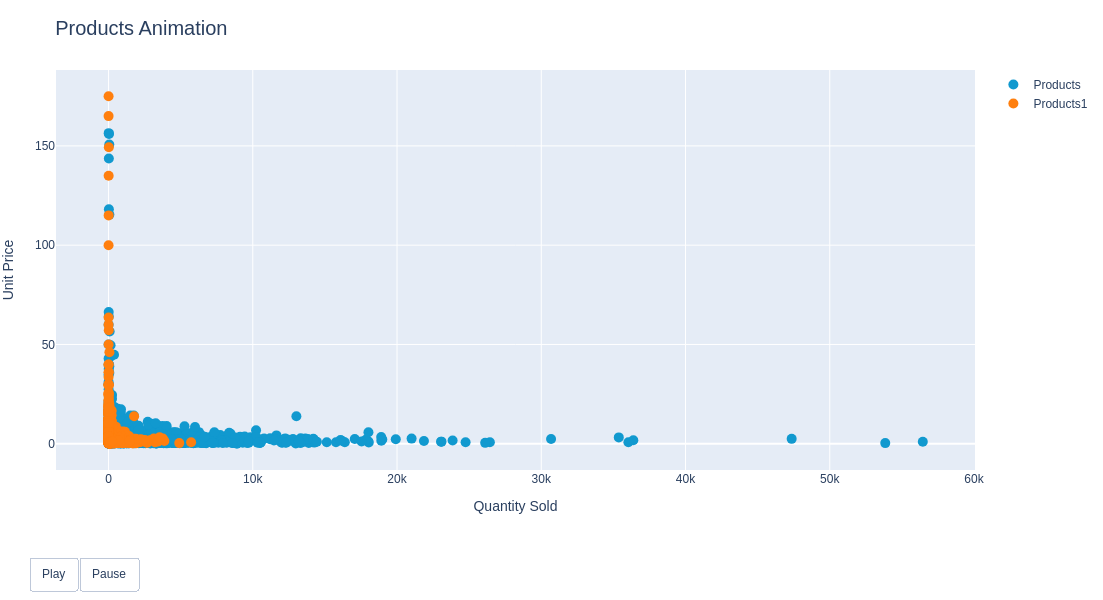

In [94]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot
import pandas as pd

# Assuming you have dataframes named 'products' and 'products1'

# Create initial trace for products
trace_products = go.Scatter(
    x = products["Quantity"],
    y = products["UnitPrice"],
    text = products["Description"],
    mode = "markers",
    name = "Products",
    marker = dict(
        size = 10,
        color = "#1199cf"
    )
)

# Create initial trace for products1 with same points as products
trace_products1_initial = go.Scatter(
    x = products["Quantity"],
    y = products["UnitPrice"],
    text = products["Description"],
    mode = "markers",
    name = "Products1",
    marker = dict(
        size = 10,
        color = "#ff7f0e"
    )
)

# Create final trace for products1
trace_products1_final = go.Scatter(
    x = products1["Quantity"],
    y = products1["UnitPrice"],
    text = products1["Description"],
    mode = "markers",
    name = "Products1",
    marker = dict(
        size = 10,
        color = "#ff7f0e"
    )
)

scatter_data_initial = [trace_products, trace_products1_initial]
scatter_data_final = [trace_products1_final]

# Define frames
frames_initial = []
frames_final = []

# Create initial frame with points from products
frame_initial = {
    "data": [],
    "name": "Products"
}
for trace in scatter_data_initial:
    frame_initial["data"].append(trace)
frames_initial.append(frame_initial)

# Create final frame with points from products1
frame_final = {
    "data": [],
    "name": "Products1"
}
for trace in scatter_data_final:
    frame_final["data"].append(trace)
frames_final.append(frame_final)

# Create figure
fig = go.Figure()

# Add initial frames to figure
for frame in frames_initial:
    fig.add_trace(frame["data"][0])  # Add only the first trace

# Update layout
layout = dict(
    title = "Products Animation",
    titlefont = dict(size = 20),
    margin=dict(l=10, r=50, b=10, t=70, pad=0),
    xaxis= dict(title= "Quantity Sold",ticklen = 5,zeroline = False),
    width=1000,  
    height=600,
    yaxis= dict(title= "Unit Price"),
    updatemenus=[{
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }]
)
fig.update_layout(layout)

# Add frames to figure
for frame in frames_final:
    fig.add_trace(frame["data"][0])  # Add only the first trace

# Save the animation as an HTML file
plot(fig, filename='products_animation.html', auto_open=False)

# Display the animation
iplot(fig)

> **We can see that same product `RAGENCY CAKESTAND 3 TIER` have again contributed most so, it's not like any christmas specific changed behaviour on single product.**

### *As we know that in february month there is valentines day. So, let's see if we can find any product which is more specific to this.*

In [107]:
# Step 1: Filter the dataframe
filtered_data = data[(data['month'] == 2) & data['Quantity']>0]
# find total quantity sold and average unit price for all products
products2 = filtered_data.groupby("Description") \
.agg({"Quantity":"sum", "UnitPrice":"mean"}).reset_index()

products2 = products2[products2["Description"].isin(["DOTCOM","Manual","Discount"]) == False] # remove for plotting

products2

Description  Quantity  UnitPrice
0               10 COLOUR SPACEBOY PEN        19      1.110
1           12 COLOURED PARTY BALLOONS         9      0.650
2            12 DAISY PEGS IN WOOD BOX         2      2.470
3            12 EGG HOUSE PAINTED WOOD         3     16.820
4     12 IVORY ROSE PEG PLACE SETTINGS        30      1.855
...                                ...       ...        ...
2577   ZINC T-LIGHT HOLDER STARS SMALL         5      0.830
2578     ZINC TOP  2 DOOR WOODEN SHELF         1     16.950
2579  ZINC WILLIE WINKIE  CANDLE STICK        10      0.980
2580       ZINC WIRE KITCHEN ORGANISER         1     20.790
2581  ZINC WIRE SWEETHEART LETTER TRAY         7      3.290

[2579 rows x 3 columns]

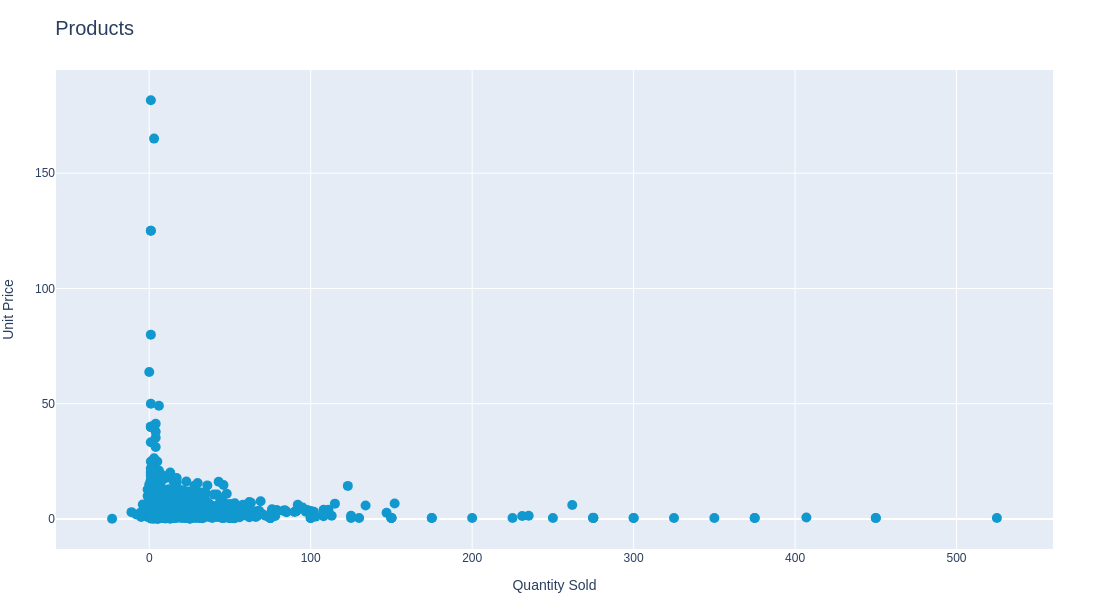

In [111]:
trace = go.Scatter(
                    x = products2["Quantity"],
                    y = products2["UnitPrice"],
                    customdata = products2["Description"],
                    hovertemplate = "%{customdata}<br>Quantity Sold: %{x}<br>UnitPrice: £%{y:.2f}<br><extra></extra>",
                    mode = "markers",
                    name = "Products",
                    line = dict(width = 4),
                    marker = dict(
                                  size = 10,
                                  color = "#1199cf"
                                 )
                    )

scatter_data = [trace]

layout = dict(
              title = "Products",
              titlefont = dict(size = 20),
              margin=dict(l=10, r=50, b=10, t=70, pad=0),
              xaxis= dict(title= "Quantity Sold",ticklen = 5,zeroline = False),
              width=1000,  
              height=600,
              yaxis= dict(title= "Unit Price")
             )
fig = dict(data = scatter_data, layout = layout)

# Save the animation as an HTML file
plot(fig, filename='most successful product overall3', auto_open=False)

iplot(fig)

> **We can see that the product such as `WRAP ENGLISH ROSE`, `GINGHAM ROSE WRAP`, `WRAP PINK FAIRY CAKES`, `SET OF 3 CAKE TINS PANTRY DESIGN` are relatively sold in higher quantity. So, during this month marketing team can target these type of customers to sell products.**

### plotnine code

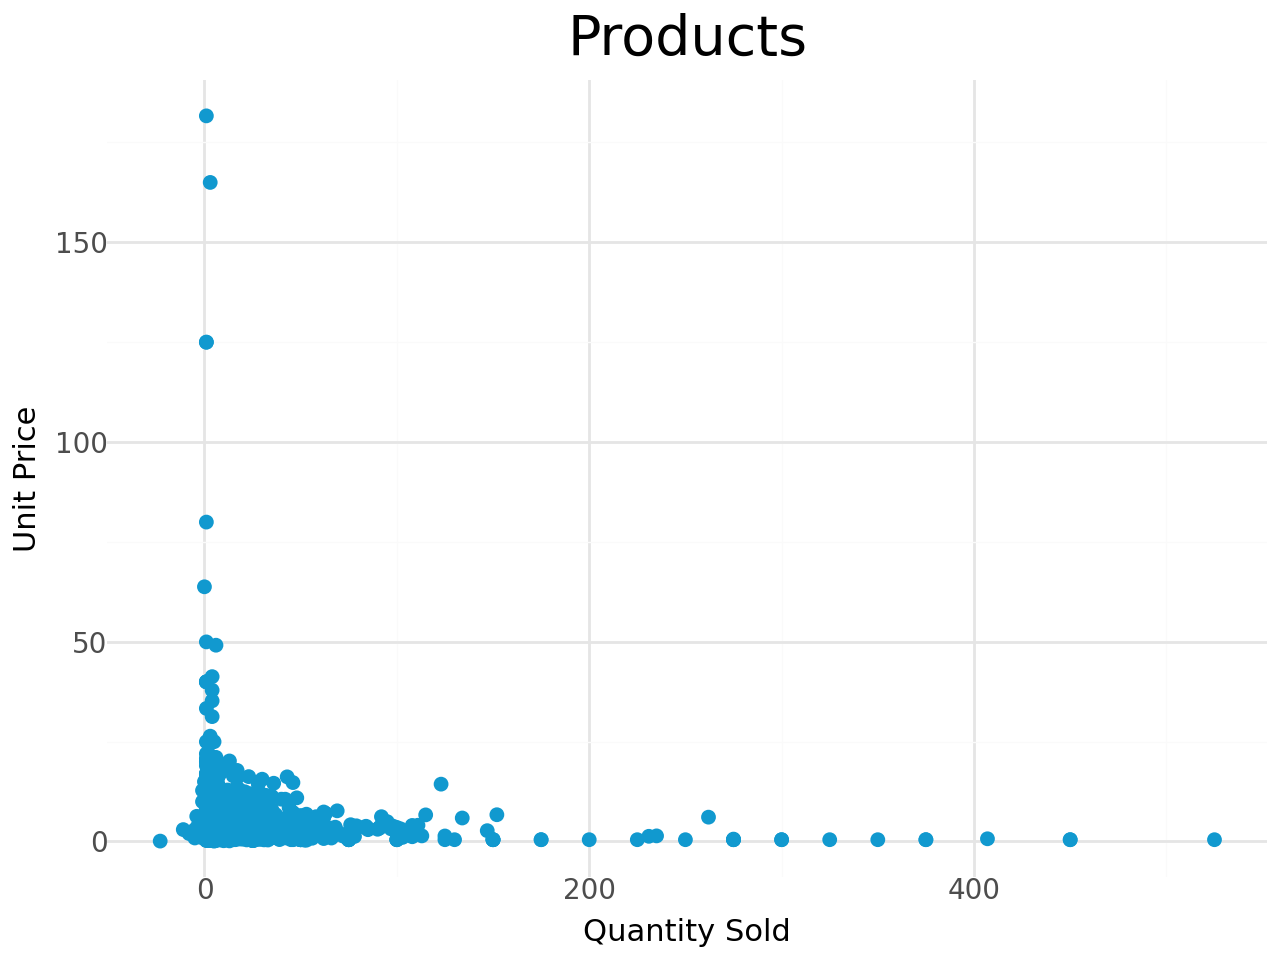

In [113]:
# Create a new DataFrame for tooltips
tooltip_df = products2[['Description', 'Quantity', 'UnitPrice']]

# Define the plot
scatter_plot = (
    ggplot(products2, aes(x='Quantity', y='UnitPrice')) +
    geom_point(size=2, color="#1199cf") +
    labs(title="Products", x="Quantity Sold", y="Unit Price") +
    theme_minimal() +
    theme(
        plot_title=element_text(size=20),
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10)
    )
)

scatter_plot

### <-----------------------------------------------------------------------------The End----------------------------------------------------------------------------->